# ABOVE AC9 Data Processing  

## Averaging replicates

**Authors:** Catherine Kuhn, Elena Terzić and Anna Simpson

**Last Updated:** September 19th, 2018

### Import libraries

In [1]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec
import inspect

### Functions

Built-in tools for this package (so far!)

In [2]:
from fopt_toolkit import fopt_toolkit as fp
for i in inspect.getmembers(fp, inspect.isfunction):
    print i[0]

get_id
make_dir
plotting_multiple_files


## Inputs

In [3]:
averaged_sample_filepath = fp.make_dir('Data/4_averaged_summary_stats')
vic_cal_filepath = fp.make_dir('Data/4_vic_averaged_summary_stats_NO_BACKSCATTER_CORRECTION')
averaged_figures_filepath = fp.make_dir('Figures/Averaged_reps')
averaged_and_vic_figures_filepath = fp.make_dir('Figures/Vic_and_averaged_reps')

### Upload metadata file with filepaths

In [4]:
metadata_updated = pd.read_csv('../Metadata/project_metadata_updated.csv', dtype={'Date': object, 'Rep':object}, skiprows=0, delimiter= '\t')



## Average replicates - replicates from 'passed second removal' folder. CALIBRATION FILES NOT INCLUDED

** Makeing filepath_dict to store files for averaging. filepath_dict keys are combinations of site, analysis type (a or c), and sample_type (fil or raw, skipping cal); entries are dictionaries containing the replicate dataframes for those variables, separated into different dataframes for means and stds **

Initializing dictionary

Example entry: filepath_dict['9mi_a_raw'] = {'mean':[], 'std':[]}

Then when filling, entries for 'mean' and 'std' will be a list of replicate dataframes for '9mi_a_raw', subset to just include the column mean or std with wl as the index. This way we can do different operations to combine the means and the stds, and then rebind the columns later.

In [5]:
### Subset the metadata to only use data that passed both removal steps
### AND does not include calibration data
temp = metadata_updated[metadata_updated['Pass_Second_Removal'] == 'pass'][metadata_updated['Sample_Type'] != 'cal']

##Empty dictionary to store dataframes for averaging
filepath_dict = {}
## Iterate through all possible unique combinations of site, analysis type, and sample type
for i in set(temp['Site']+'_'+temp['Analysis_Type']+'_'+temp['Sample_Type']):
    ## Entries of dictionary are a dictionary with entries 'mean' and 'std
    filepath_dict[i] = {'mean':[], 'std':[]}


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Filling dictionary

In [6]:
### iterate through the rows of the subsetted metadata
for index, row in temp.iterrows():
    ## Get information for each row to match the key value of filepath_dict
    site = row['Site']
    analysis_type = row['Analysis_Type']
    sample_type = row['Sample_Type']
    key_value = site+'_'+analysis_type+'_'+sample_type
    ## Read in the csv based on the filepath
    df = pd.read_csv(row['Summary_file_path_cleaned_MANUAL'], skiprows = 0, delimiter= '\t')         
    df.reset_index(inplace=True, drop=False)
    ## Rename columns so we don't have to write multiple lines of code
    df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
    ## store means and stds separately for each set of reps to be averaged
    ## Becaue they require different operations
    ## (index values are wavelengths)
    filepath_dict[key_value]['mean'].append(df[['wl','mean']].set_index('wl'))
    filepath_dict[key_value]['std'].append(df[['wl','std']].set_index('wl'))

In [7]:
wavelengths = list(df['wl'])

In [8]:
wavelengths

[412.0, 440.0, 488.0, 510.0, 532.0, 555.0, 650.0, 676.0, 715.0]

** Custom aggregation function for combining standard deviations: for standard deviations x and y, combined std = sqrt(x^2 + y^2) **

In [9]:
def combine_std(series):
    from math import sqrt
    return sqrt(sum([i**2 for i in series]))

In [10]:
averaged_files = {i.split('_')[0]:{'a':{'fil':None,'raw':None},\
                                   #'b':{'fil':None,'raw':None},\
                                   'c':{'fil':None,'raw':None},\
                                   'va':{'vic':None},\
                                   #'vb':{'vic':None},\
                                   'vc':{'vic':None},\
                                  } for i in filepath_dict}
for i in filepath_dict:
    site = i.split('_')[0]
    a_type = i.split('_')[1]
    s_type = i.split('_')[2]
    means = pd.concat(filepath_dict[i]['mean']).groupby(level=0).mean()
    stds = pd.concat(filepath_dict[i]['std']).groupby(level=0).agg(combine_std)
    #temp_series = temp_series.to_frame(name=i)
    means['std'] = stds['std']
    averaged_files[site][a_type][s_type] = means

In [11]:
averaged_sample_filepath

'/Users/Petrichor/Documents/FreshwatersOpticsToolkit/Data/4_averaged_summary_stats'

In [12]:
vic_cal_filepath

'/Users/Petrichor/Documents/FreshwatersOpticsToolkit/Data/4_vic_averaged_summary_stats'

In [13]:
for i in averaged_files:
    ## define averaged files
    absorption_raw = averaged_files[i]['a']['raw']
    absorption_fil = averaged_files[i]['a']['fil']
    attenuation_raw = averaged_files[i]['c']['raw']
    attenuation_fil = averaged_files[i]['c']['fil']
    ## Calculate means for backscatter
    #raw_scatter_mean = attenuation_raw[['mean']]-absorption_raw[['mean']]
    #fil_scatter_mean = attenuation_fil[['mean']]-absorption_fil[['mean']]
    ## Calculate standard deviations for backscatter
    #raw_scatter_std = pd.concat([absorption_raw[['std']], attenuation_raw[['std']]]).groupby(level=0).agg(combine_std)
    #fil_scatter_std = pd.concat([absorption_fil[['std']], attenuation_fil[['std']]]).groupby(level=0).agg(combine_std)
    ## Append standard deviations
    #raw_scatter_mean['std'] = raw_scatter_std['std']
    #fil_scatter_mean['std'] = fil_scatter_std['std']
    ## Add backscatter dataframes to dictionary for plotting
    #averaged_files[i]['b']['raw'] = raw_scatter_mean
    #averaged_files[i]['b']['fil'] = fil_scatter_mean
    ## Calculating vicarious calibration means
    vic_absorption_mean = absorption_raw[['mean']]-absorption_fil[['mean']]
    vic_attenuation_mean = attenuation_raw[['mean']] - attenuation_fil[['mean']]
    #vic_scatter_mean = raw_scatter_mean[['mean']] - fil_scatter_mean[['mean']]
    ## Calculating standard deviations for vicarious calibration
    vic_absorption_std = pd.concat([absorption_raw[['std']], absorption_fil[['std']]]).groupby(level=0).agg(combine_std)
    vic_attenuation_std = pd.concat([attenuation_raw[['std']], attenuation_fil[['std']]]).groupby(level=0).agg(combine_std)
    #vic_scatter_std = pd.concat([raw_scatter_mean[['std']], fil_scatter_mean[['std']]]).groupby(level=0).agg(combine_std)
    ## Putting new standard deviations into vicarious calibration dataframes
    vic_absorption_mean['std'] = vic_absorption_std['std']
    vic_attenuation_mean['std'] = vic_attenuation_std['std']
    #vic_scatter_mean['std'] = vic_scatter_std['std']
    ## Adding vicarious calibration dataframes to dictionary for plotting
    averaged_files[i]['va']['vic'] = vic_absorption_mean
    averaged_files[i]['vc']['vic'] = vic_attenuation_mean
    #averaged_files[i]['vb']['vic'] = vic_scatter_mean
    ### Save averaged files
    absorption_raw.to_csv(averaged_sample_filepath+'/Averaged_'+i+'_'+'a_raw.csv', sep='\t',index=False)
    absorption_fil.to_csv(averaged_sample_filepath+'/Averaged_'+i+'_'+'a_fil.csv', sep='\t',index=False)
    attenuation_raw.to_csv(averaged_sample_filepath+'/Averaged_'+i+'_'+'c_raw.csv', sep='\t',index=False)
    attenuation_fil.to_csv(averaged_sample_filepath+'/Averaged_'+i+'_'+'c_fil.csv', sep='\t',index=False)
    #raw_scatter_mean.to_csv(averaged_sample_filepath+'/Averaged_'+i+'_'+'b_raw.csv', sep='\t',index=False)
    #fil_scatter_mean.to_csv(averaged_sample_filepath+'/Averaged_'+i+'_'+'b_fil.csv', sep='\t',index=False)
    ## Save vicariously calibrated files
    vic_absorption_mean.to_csv(vic_cal_filepath+'/Vical_'+i+'_'+'a.csv', sep='\t',index=False)
    vic_attenuation_mean.to_csv(vic_cal_filepath+'/Vical_'+i+'_'+'c.csv', sep='\t',index=False)
    #vic_scatter_mean.to_csv(vic_cal_filepath+'/Vical_'+i+'_'+'b.csv', sep='\t',index=False)

** Plotting averaged absorption, backscatter, and attenuation **

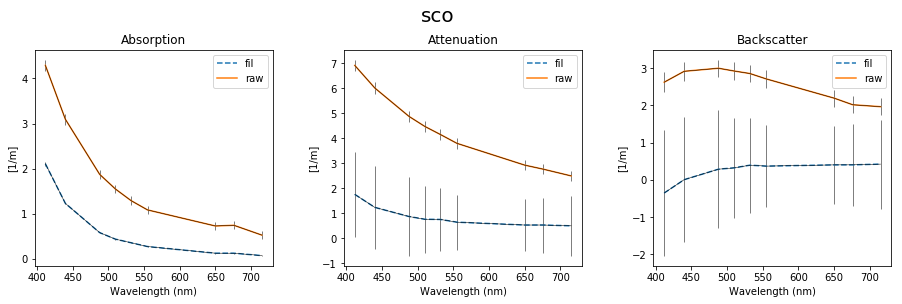

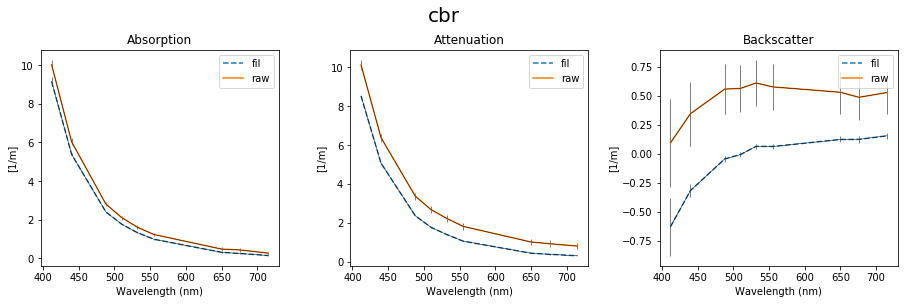

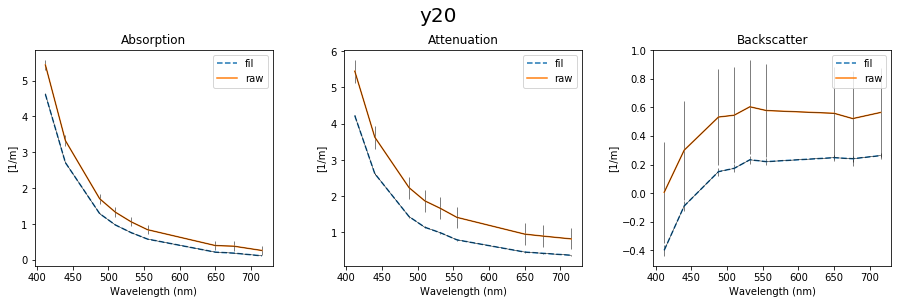

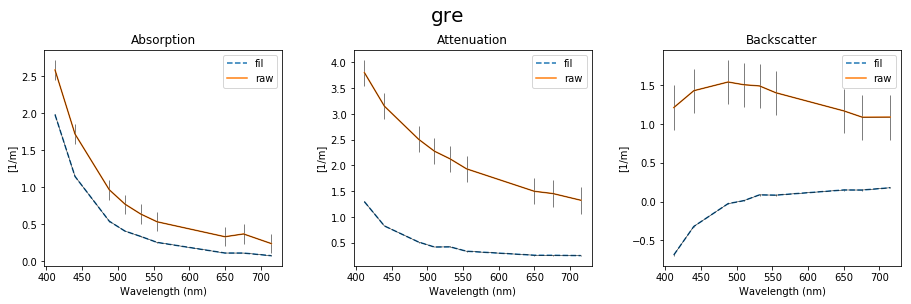

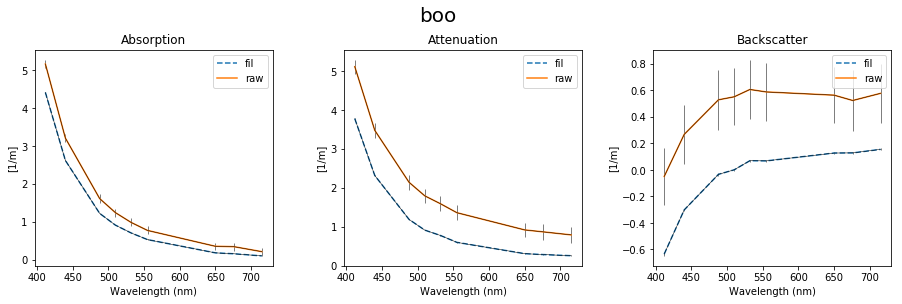

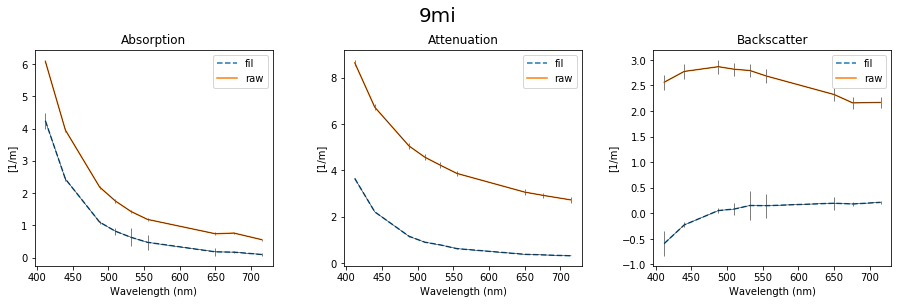

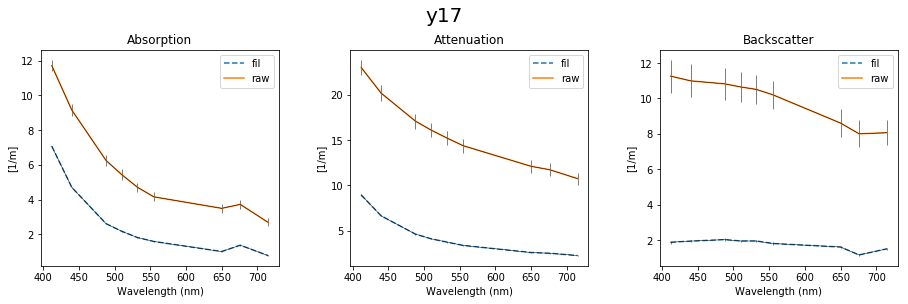

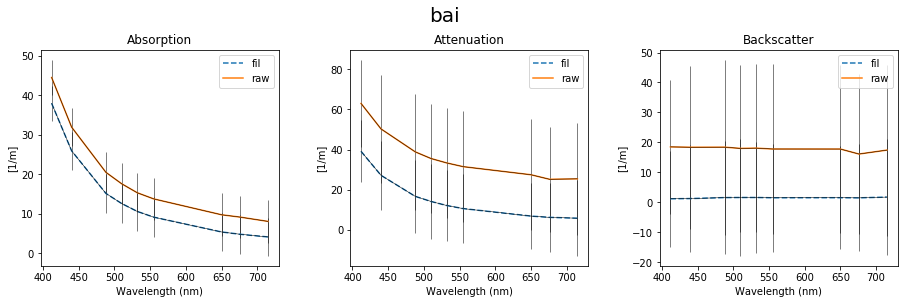

In [14]:
for i in averaged_files:
    absorption = averaged_files[i]['a']
    attenuation = averaged_files[i]['c']
    scatter = averaged_files[i]['b']
    plt.subplots(1, 3, figsize=(14, 4))
    plt.subplot(1, 3, 1)
    fp.plotting_multiple_files(absorption, title='Absorption')
    plt.subplot(1, 3, 2)
    fp.plotting_multiple_files(attenuation, title='Attenuation')
    plt.subplot(1, 3, 3)
    fp.plotting_multiple_files(scatter, title='Backscatter')
    plt.subplots_adjust(top=0.83, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.3)
    plt.suptitle(i, fontsize=20)
    plt.savefig(averaged_figures_filepath+'/Averaged_'+i+'.png', bbox_inches='tight')
    plt.show()

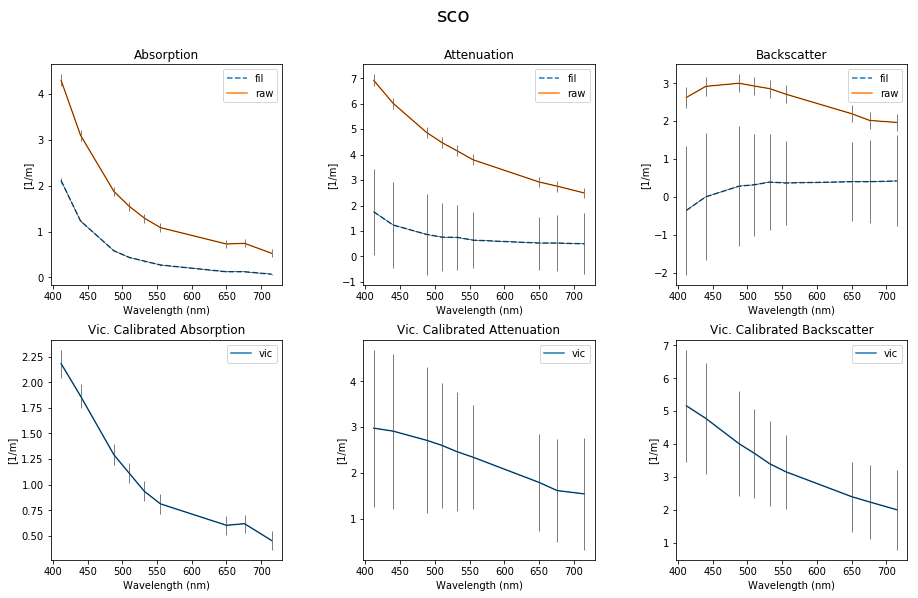

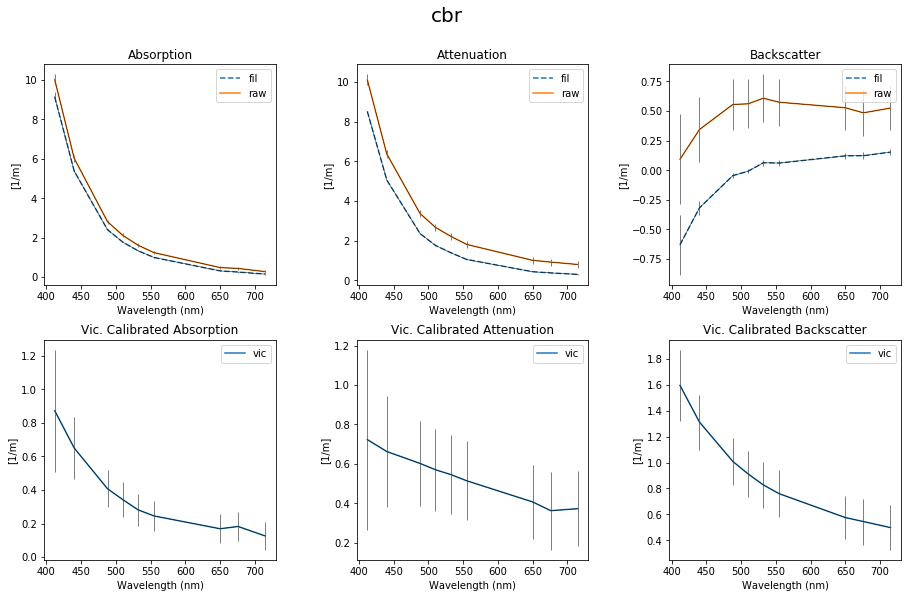

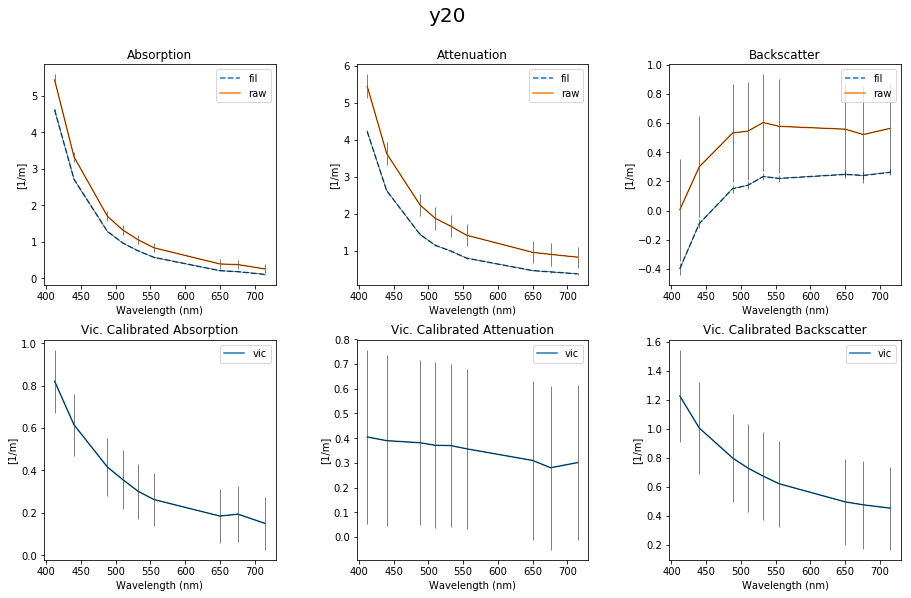

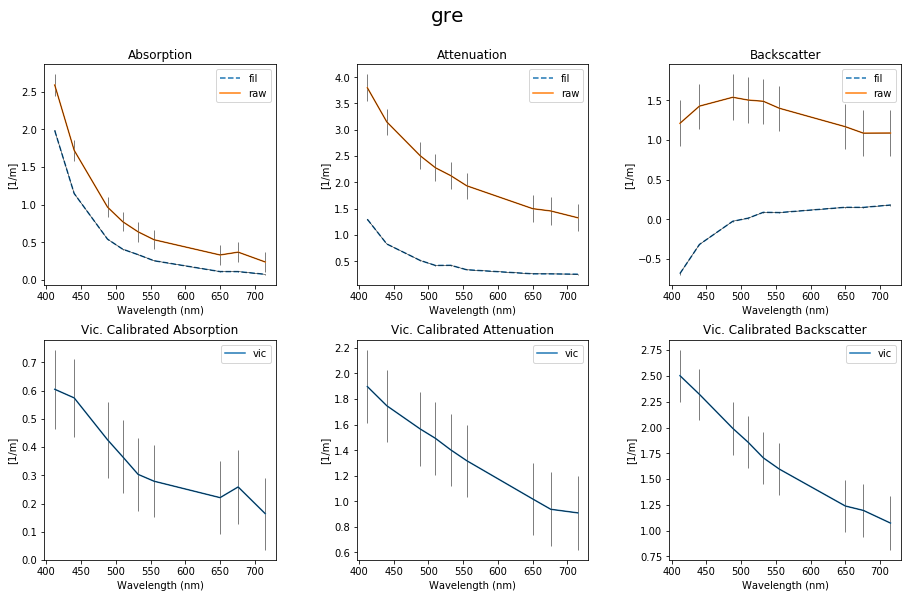

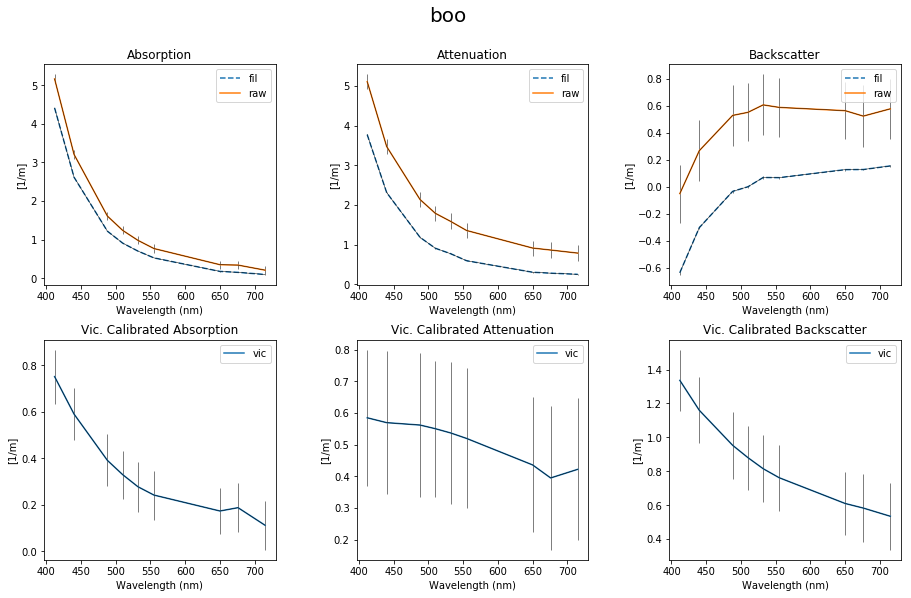

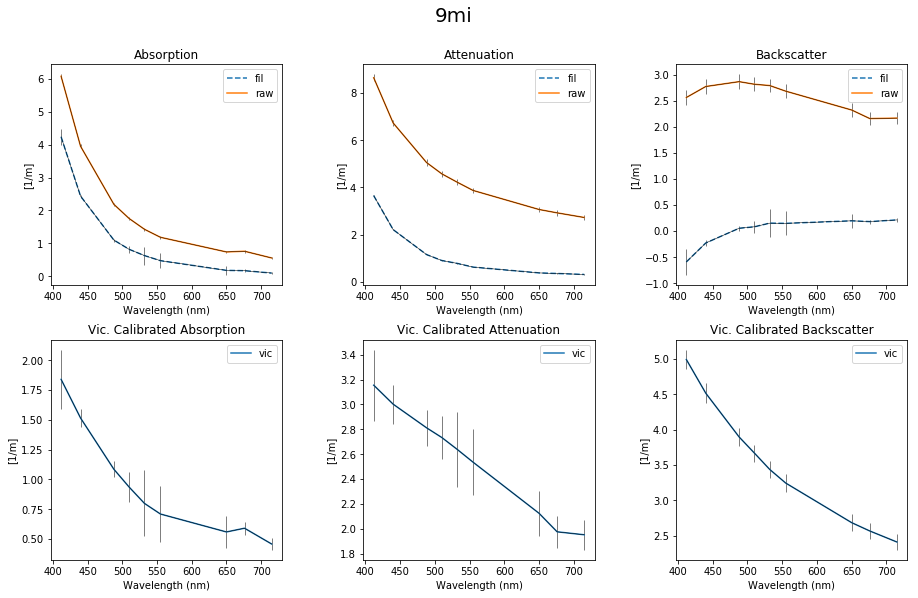

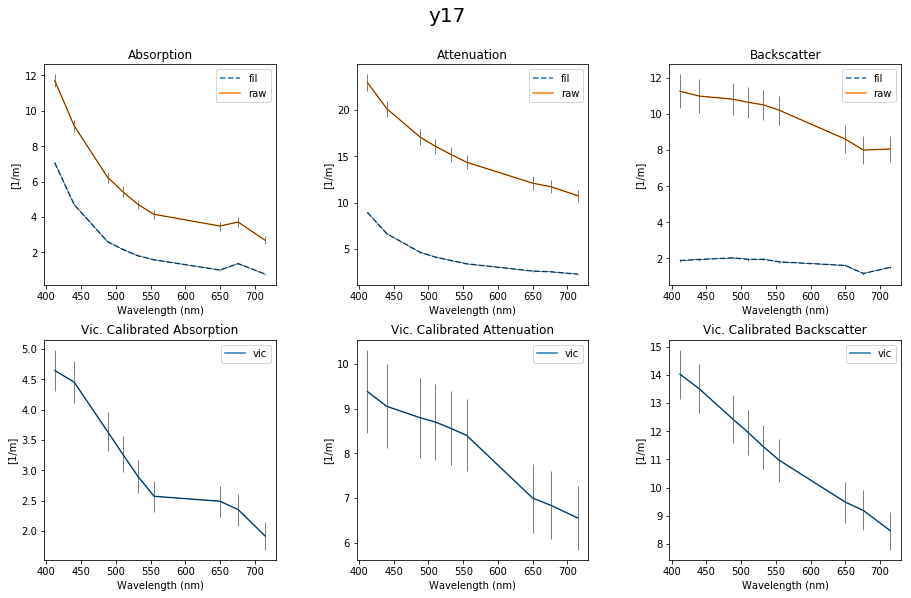

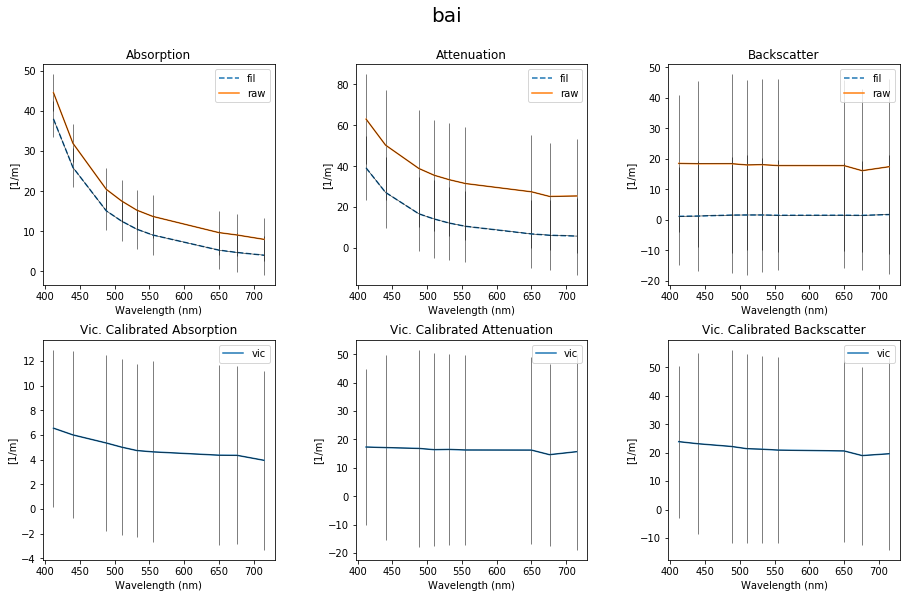

In [15]:
for i in averaged_files:
    absorption = averaged_files[i]['a']
    attenuation = averaged_files[i]['c']
    scatter = averaged_files[i]['b']
    vic_absorption = averaged_files[i]['va']
    vic_attenuation = averaged_files[i]['vc']
    vic_scatter = averaged_files[i]['vb']
    plt.subplots(2, 3, figsize=(14, 8))
    plt.subplot(2, 3, 1)
    fp.plotting_multiple_files(absorption, title='Absorption')
    plt.subplot(2, 3, 2)
    fp.plotting_multiple_files(attenuation, title='Attenuation')
    plt.subplot(2, 3, 3)
    fp.plotting_multiple_files(scatter, title='Backscatter')
    plt.subplot(2, 3, 4)
    fp.plotting_multiple_files(vic_absorption, title='Vic. Calibrated Absorption')
    plt.subplot(2, 3, 5)
    fp.plotting_multiple_files(vic_attenuation, title='Vic. Calibrated Attenuation')
    plt.subplot(2, 3, 6)
    fp.plotting_multiple_files(vic_scatter, title='Vic. Calibrated Backscatter')
    plt.subplots_adjust(top=0.88, bottom=0.02, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle(i, fontsize=20)
    plt.savefig(averaged_and_vic_figures_filepath+'/Vicariosly_calibrated_'+i+'.png', bbox_inches='tight')
    plt.show()